In [1]:
# Import Libraries
import numpy as np
import h5py
import gc
import librosa
import os
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import librosa
import os
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ELU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import AveragePooling2D

# Clear Session
K.clear_session()
gc.collect()

0

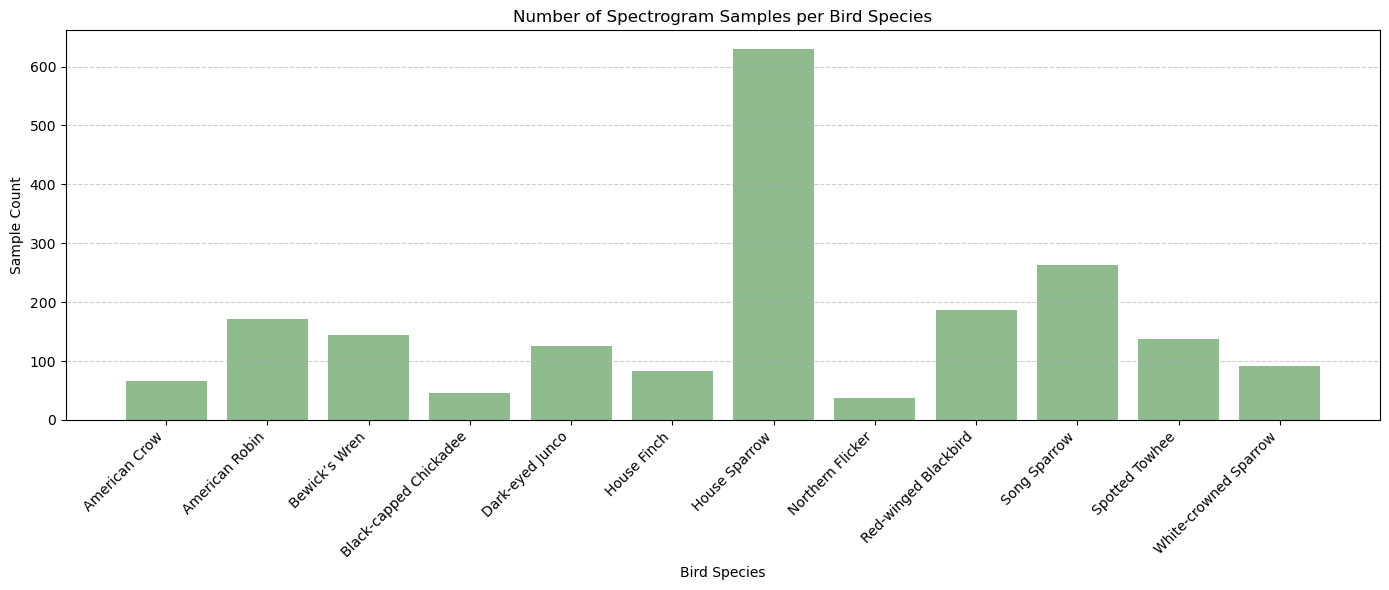

In [2]:
# Mapping from short code to full species name
species_fullnames = {
    'amecro': 'American Crow',
    'amerob': 'American Robin',
    'bewwre': "Bewick’s Wren",
    'bkcchi': 'Black-capped Chickadee',
    'daejun': 'Dark-eyed Junco',
    'houfin': 'House Finch',
    'houspa': 'House Sparrow',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'sonspa': 'Song Sparrow',
    'spotow': 'Spotted Towhee',
    'whcspa': 'White-crowned Sparrow'
}

# Load Data
f = h5py.File('bird_spectrograms.hdf5', 'r')
species_keys = list(f.keys())
species_counts = {key: f[key].shape[2] for key in species_keys}

# Map codes to full names
species_labels = [species_fullnames[key] for key in species_keys]
counts = [species_counts[key] for key in species_keys]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(species_labels, counts, color='darkseagreen')
plt.title("Number of Spectrogram Samples per Bird Species")
plt.xlabel("Bird Species")
plt.ylabel("Sample Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Binary Classifier

In [4]:
# Binary Classifier I
# Transpose and load data
bird1 = np.transpose(f['amerob'][:], (2, 0, 1))  
bird2 = np.transpose(f['rewbla'][:], (2, 0, 1))  

# Add channel dimension
bird1 = bird1[..., np.newaxis]  
bird2 = bird2[..., np.newaxis]

# Combine dataset
X = np.concatenate([bird1, bird2], axis=0)
y = np.concatenate([np.zeros(len(bird1)), np.ones(len(bird2))])

# Normalize per sample
X = (X - np.min(X, axis=(1, 2, 3), keepdims=True)) / (
     np.max(X, axis=(1, 2, 3), keepdims=True) - np.min(X, axis=(1, 2, 3), keepdims=True) + 1e-6
)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Define CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Final accuracy\
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal validation accuracy: {final_val_acc:.4f}")

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4178 - auc: 0.4520 - loss: 2.5809 - precision: 0.4410 - recall: 0.5984 - val_accuracy: 0.4889 - val_auc: 0.5730 - val_loss: 0.8400 - val_precision: 1.0000 - val_recall: 0.0213
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.5058 - auc: 0.5127 - loss: 0.8351 - precision: 0.5355 - recall: 0.4504 - val_accuracy: 0.5556 - val_auc: 0.5537 - val_loss: 0.6964 - val_precision: 0.6000 - val_recall: 0.4468
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.6285 - auc: 0.6727 - loss: 0.6568 - precision: 0.6433 - recall: 0.7265 - val_accuracy: 0.5222 - val_auc: 0.5589 - val_loss: 0.6953 - val_precision: 0.5455 - val_recall: 0.5106
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.7287 - auc: 0.7795 - loss: 0.6204 - precision: 0.8285 - recall: 0.5745 - val_accuracy: 0.5667 - val_auc: 0.5854 - val_loss: 0.6930 - val_precision: 0.5690 - val_recall: 0.7021
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step -

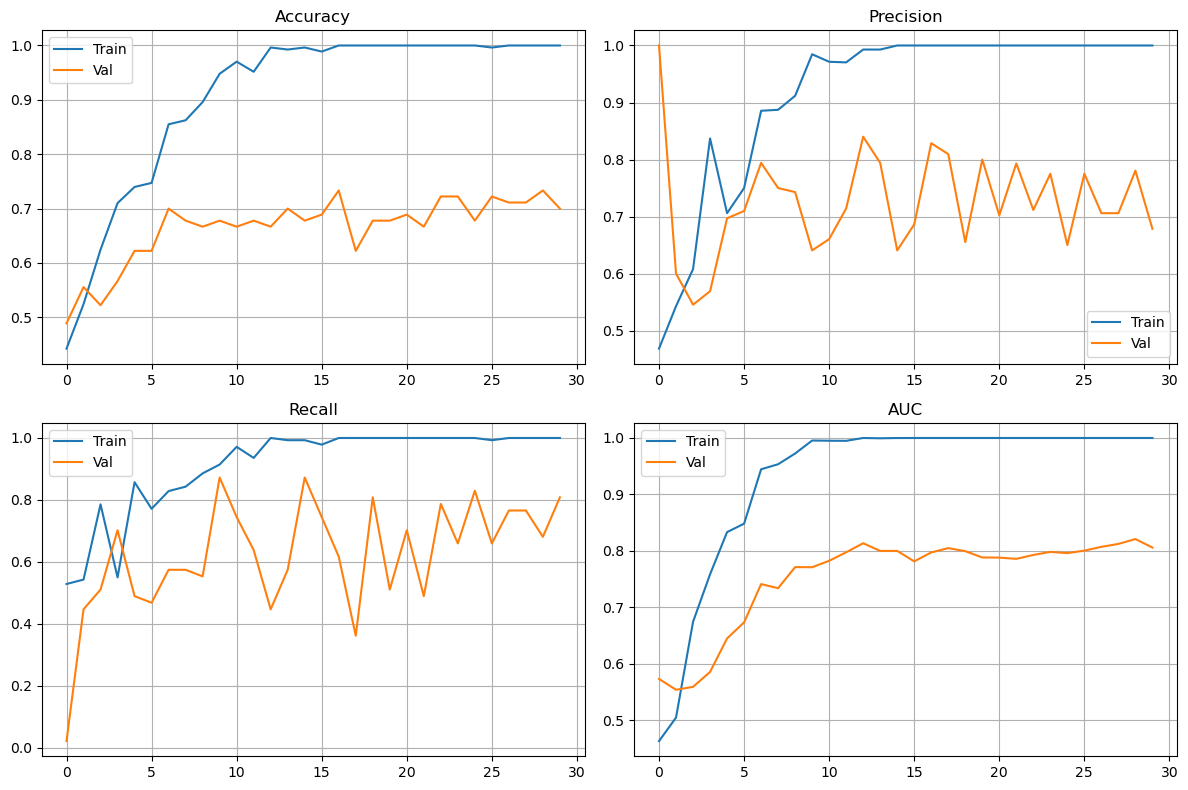

In [5]:
# Plots
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Binary Model I with Early Stopping
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Print Validation Accuracy
final_val_acc = history.history['val_accuracy'][-1]
print(f"\n Final validation accuracy: {final_val_acc:.4f}")

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0039 - precision: 1.0000 - recall: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0040 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7111 - val_auc: 0.7956 - val_loss: 0.8762 - val_precision: 0.8182 - val_recall: 0.5745
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0065 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6889 - val_auc: 0.7909 - val_loss: 0.9290 - val_precision: 0.6610 - val_recall: 0.8298
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0061 - precision: 1.0000 - recall: 0.9951 - val_accuracy: 0.6778 - val_auc: 0.7838 - val_loss: 0.9281 - val_precision: 0.6500 - val_recall: 0.8298
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0032 - precision: 1.0000 - recall: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0031 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6889 - val_auc: 0.7850 - val_loss: 0.8414 - val_precision: 0.7436 - val_recall: 0.6170
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0053 - precision: 1.0000 - recall: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0052 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7000 - val_auc: 0.7924 - val_loss: 0.8292 - val_precision: 0.6923 - val_recall: 0.7660
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0033 - precision: 1.0000 - recall: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0035 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7000 - val_auc: 0.7971 - val_loss: 0.8266 - val_precision: 0.6923 - val_recall: 0.7660
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0032 - precision: 1.0000 - recall: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0032 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7222 - val_auc: 0.7939 - val_loss: 0.7963 - val_precision: 0.7500 - val_recall: 0.7021
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0052 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6889 - val_auc: 0.7934 - val_loss: 0.9309 - val_precision: 0.6610 - val_recall: 0.8298
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0031 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6889 - val_auc: 0.7969 - val_loss: 0.8373 - val_precision: 0.7209 - val_recall: 0.6596
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0020 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7000 - val_auc: 0.7934 - val_loss: 0.8603 - val_precision: 0.7273 - val_recall: 0.6809
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step

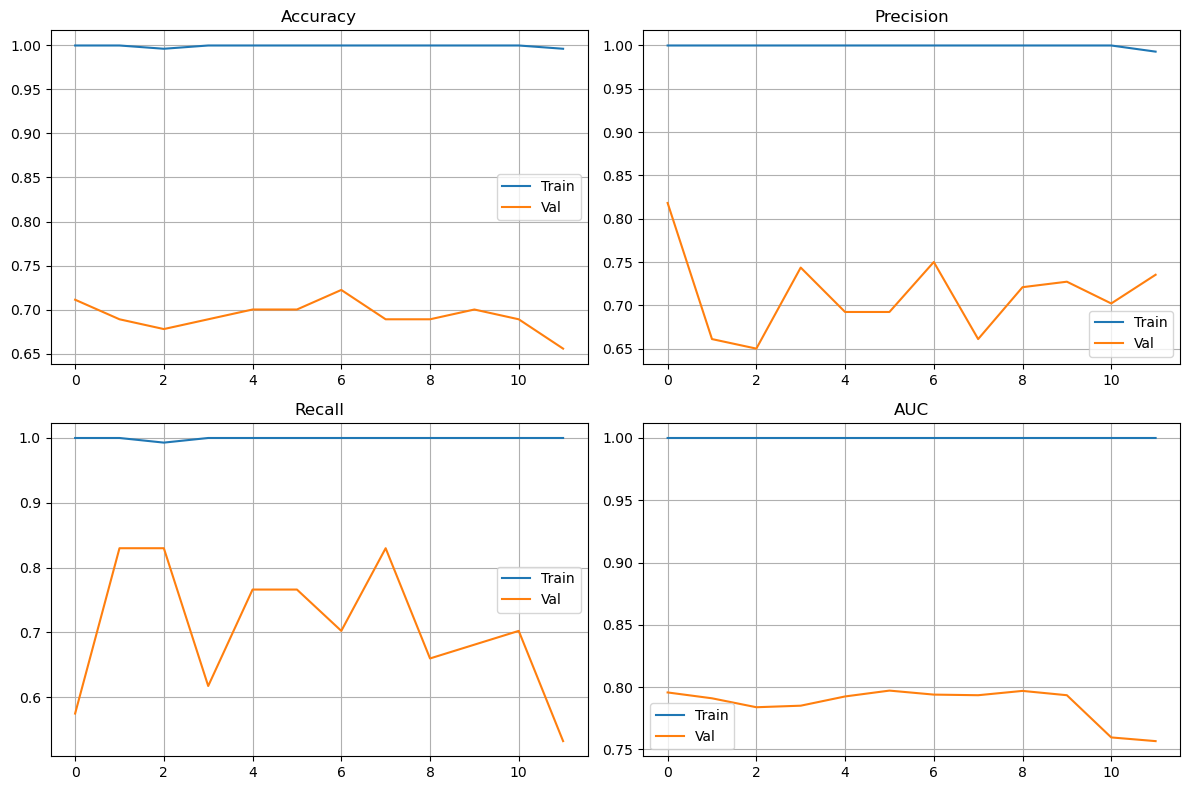

In [7]:
# Plots
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Clear previous models from memory
K.clear_session()
gc.collect()

0

In [9]:
# Binary Classifier II 
# Normalize X 
X = (X - X.min(axis=(1, 2, 3), keepdims=True)) / (X.max(axis=(1, 2, 3), keepdims=True) - X.min(axis=(1, 2, 3), keepdims=True) + 1e-6)

# Split and Encode Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train).flatten()
y_test = lb.transform(y_test).flatten()

# Define CNN
model1 = Sequential()
model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(8, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Flatten())
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))

#Compile the Model
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

history = model1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test)
)

# Print Validation Accuracy
print(f"\nFinal validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.4965 - auc: 0.5466 - loss: 0.9246 - precision: 0.4883 - recall: 0.5648 - val_accuracy: 0.4889 - val_auc: 0.5344 - val_loss: 0.6939 - val_precision: 0.6000 - val_recall: 0.0638
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5175 - auc: 0.5263 - loss: 0.6834 - precision: 0.5413 - recall: 0.6490 - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: 0.6923 - val_precision: 0.5222 - val_recall: 1.0000
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5062 - auc: 0.5279 - loss: 0.6853 - precision: 0.5004 - recall: 0.7573 - val_accuracy: 0.4778 - val_auc: 0.5668 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5851 - auc: 0.6523 - loss: 0.6588 - precision: 0.6292 - recall: 0.3941 - val_accuracy: 0.5778 - val_auc: 0.6316 - val_loss: 0.6907 - val_precision: 0.5529 - val_recall: 1.0000
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━

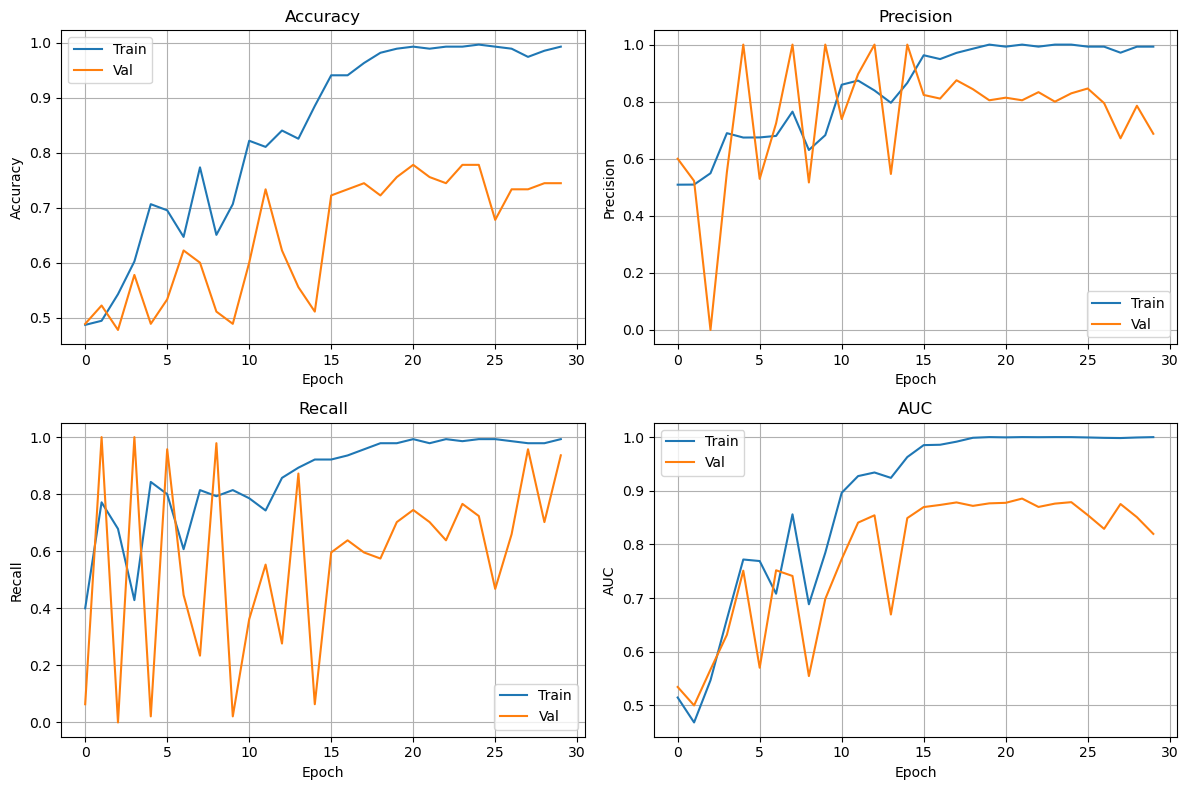

In [10]:
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Binary Classifier III (more parameters as per feedback)

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 517, 1)))
model2.add(BatchNormalization())
model2.add(LeakyReLU())
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(LeakyReLU())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(LeakyReLU())
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

history2 = model2.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_test, y_test)
)

# Print Validation Accuracy
print(f"\nFinal validation accuracy: {history2.history['val_accuracy'][-1]:.4f}")

Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - accuracy: 0.4312 - auc: 0.4310 - loss: 4.7964 - precision: 0.4337 - recall: 0.4362 - val_accuracy: 0.5556 - val_auc: 0.5623 - val_loss: 0.7778 - val_precision: 0.6061 - val_recall: 0.4255
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 562ms/step - accuracy: 0.5972 - auc: 0.6567 - loss: 0.7439 - precision: 0.6519 - recall: 0.5450 - val_accuracy: 0.5667 - val_auc: 0.5772 - val_loss: 0.7774 - val_precision: 0.5952 - val_recall: 0.5319
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 568ms/step - accuracy: 0.6165 - auc: 0.6724 - loss: 0.7456 - precision: 0.5973 - recall: 0.7777 - val_accuracy: 0.5222 - val_auc: 0.6393 - val_loss: 0.7744 - val_precision: 0.5222 - val_recall: 1.0000
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 569ms/step - accuracy: 0.6660 - auc: 0.7260 - loss: 0.6834 - precision: 0.6686 - recall: 0.7685 - val_accuracy: 0.5222 - val_auc: 0.6361 - val_loss: 0.7722 - val_precision: 0.5222 - val_recall: 1.0000
Epoch 5/40
17/17 ━━━━━━━━━━━

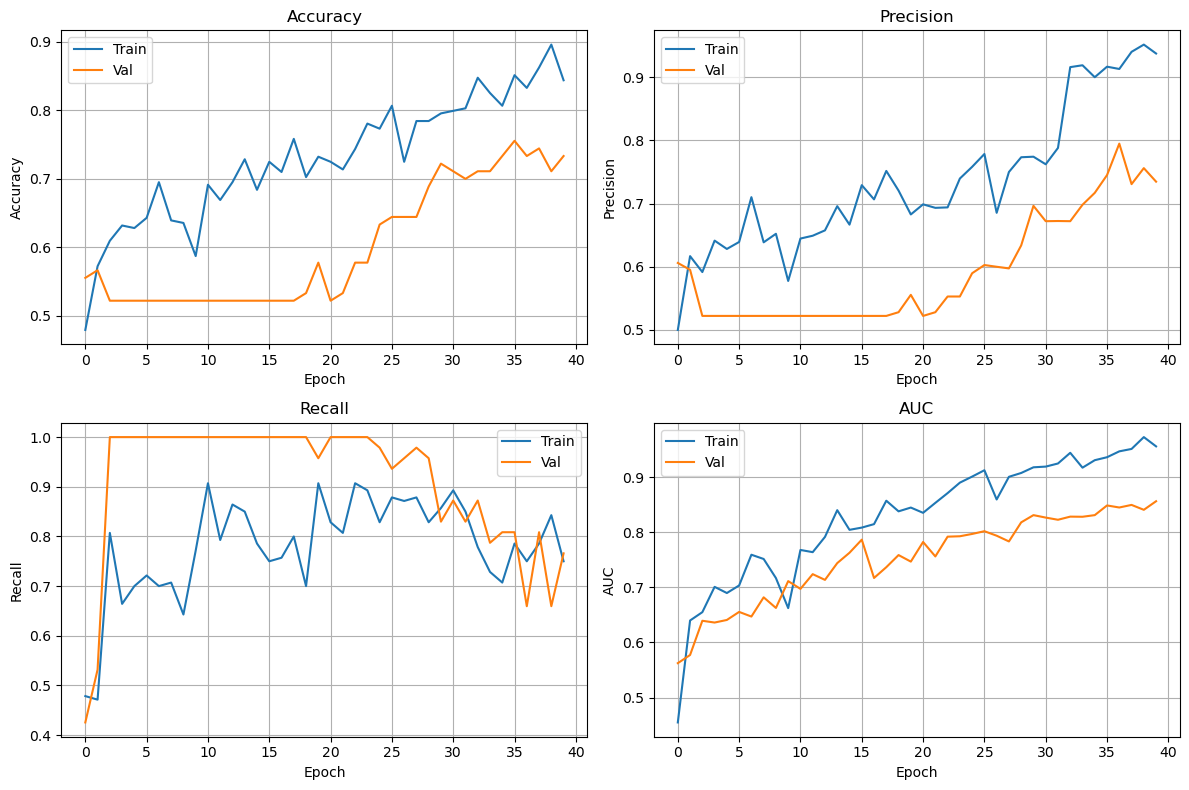

In [12]:
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history2.history['precision'], label='Train')
plt.plot(history2.history['val_precision'], label='Val')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history2.history['recall'], label='Train')
plt.plot(history2.history['val_recall'], label='Val')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history2.history['auc'], label='Train')
plt.plot(history2.history['val_auc'], label='Val')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Binary Classifier 4 (more parameters as per feedback)

model3 = Sequential()
model3.add(Conv2D(16, (5, 5), activation='elu', input_shape=(128, 517, 1)))
model3.add(AveragePooling2D((2, 2)))

model3.add(Conv2D(32, (3, 3), activation='elu'))
model3.add(AveragePooling2D((2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(32, activation='elu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

history3 = model3.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Print Validation Accuracy
print(f"\nFinal validation accuracy: {history3.history['val_accuracy'][-1]:.4f}")

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.4916 - auc: 0.5081 - loss: 1.3151 - precision: 0.5368 - recall: 0.4875 - val_accuracy: 0.4889 - val_auc: 0.5542 - val_loss: 0.9648 - val_precision: 1.0000 - val_recall: 0.0213
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5120 - auc: 0.5664 - loss: 0.8739 - precision: 0.4255 - recall: 0.3155 - val_accuracy: 0.5333 - val_auc: 0.5477 - val_loss: 0.7294 - val_precision: 0.8571 - val_recall: 0.1277
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.5014 - auc: 0.5806 - loss: 0.7197 - precision: 0.5098 - recall: 0.4050 - val_accuracy: 0.5222 - val_auc: 0.5700 - val_loss: 0.7347 - val_precision: 0.8333 - val_recall: 0.1064
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.6237 - auc: 0.6344 - loss: 0.6896 - precision: 0.6744 - recall: 0.5673 - val_accuracy: 0.4889 - val_auc: 0.5589 - val_loss: 0.7365 - val_precision: 0.5068 - val_recall: 0.7872
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2

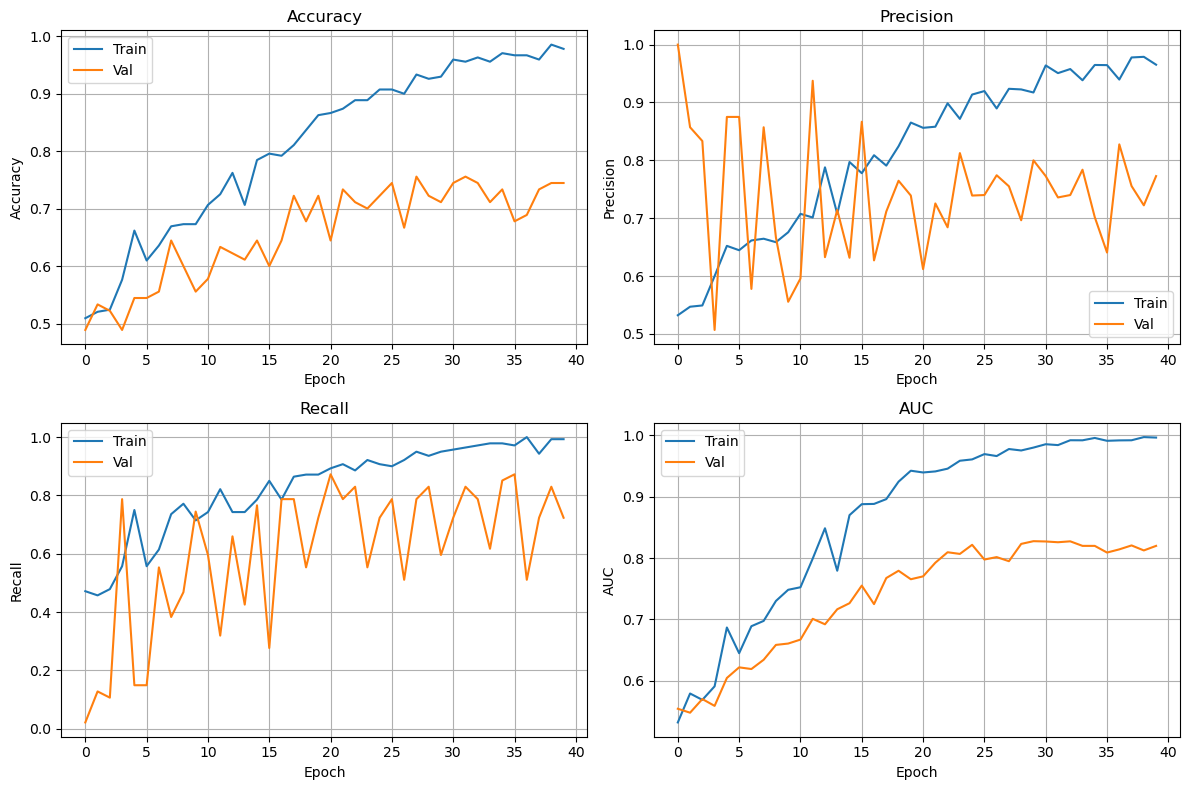

In [14]:
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history3.history['precision'], label='Train')
plt.plot(history3.history['val_precision'], label='Val')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history3.history['recall'], label='Train')
plt.plot(history3.history['val_recall'], label='Val')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history3.history['auc'], label='Train')
plt.plot(history3.history['val_auc'], label='Val')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


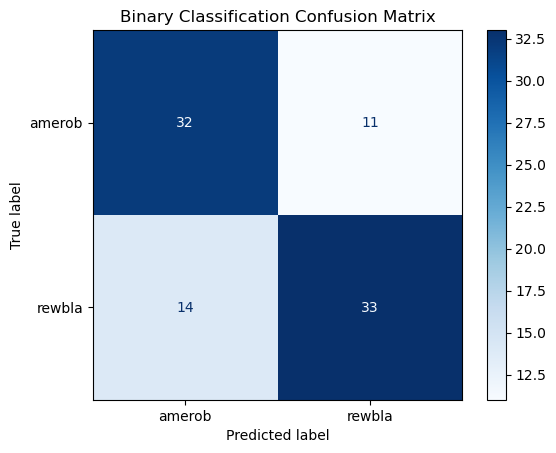

In [15]:
#Confusion Matrix 
# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["amerob", "rewbla"])
disp.plot(cmap='Blues')
plt.title("Binary Classification Confusion Matrix")
plt.show()

### Multi-Class Classifier

In [17]:
# Clear Session
K.clear_session()
gc.collect()

0

In [18]:
# Multi-class on Subset Data 
# Load Subset of Data

X = []
y = []

for species in species_keys:
    data = f[species][:]                   
    data = np.transpose(data, (2, 0, 1))     
    data = data[:300]                        
    data = data[..., np.newaxis]             
    X.append(data)
    y.extend([species] * data.shape[0])

# Combine and Normalize 
X = np.concatenate(X, axis=0)
y = np.array(y)

X = (X - np.min(X, axis=(1, 2, 3), keepdims=True)) / (
    np.max(X, axis=(1, 2, 3), keepdims=True) - np.min(X, axis=(1, 2, 3), keepdims=True) + 1e-6
)

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(species_keys))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.25, stratify=y_cat, random_state=42
)

# Define multi-class CNN Model
model_multiclass = Sequential()

model_multiclass.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model_multiclass.add(BatchNormalization())
model_multiclass.add(MaxPooling2D((2, 2)))

model_multiclass.add(Conv2D(32, (3, 3), activation='relu'))
model_multiclass.add(BatchNormalization())
model_multiclass.add(MaxPooling2D((2, 2)))

model_multiclass.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass.add(BatchNormalization())
model_multiclass.add(MaxPooling2D((2, 2)))

model_multiclass.add(GlobalAveragePooling2D())
model_multiclass.add(Dense(64, activation='relu'))
model_multiclass.add(Dense(len(species_keys), activation='softmax'))

# Compile the Model
model_multiclass.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history = model_multiclass.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass.evaluate(X_test, y_test)
print(f"\n Subset test accuracy: {acc:.4f}")

Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - accuracy: 0.1287 - loss: 2.4142 - val_accuracy: 0.1598 - val_loss: 2.4234
Epoch 2/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.2026 - loss: 2.2891 - val_accuracy: 0.1574 - val_loss: 2.3714
Epoch 3/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 448s 6s/step - accuracy: 0.1537 - loss: 2.3040 - val_accuracy: 0.1816 - val_loss: 2.3487
Epoch 4/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.2004 - loss: 2.2776 - val_accuracy: 0.1477 - val_loss: 2.4392
Epoch 5/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.2189 - loss: 2.2576 - val_accuracy: 0.1840 - val_loss: 2.4754
Epoch 6/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.2240 - loss: 2.2445 - val_accuracy: 0.1816 - val_loss: 2.4434
Epoch 7/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.2284 - loss: 2.2301 - val_accuracy: 0.1913 - val_loss: 2.4018
Epoch 8/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.2788 - loss: 2.1934 - val_accuracy: 0.1404 

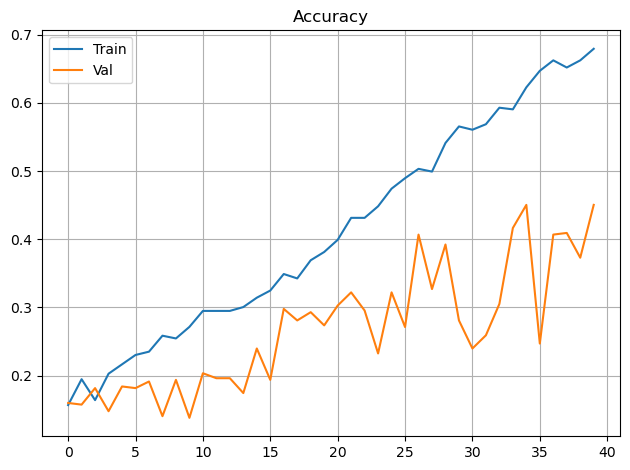

In [19]:
# Plot

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Multi-class on Full Dataset

X = []
y = []

for species in species_keys:
    data = f[species][:]                      
    data = np.transpose(data, (2, 0, 1))      
    data = data[..., np.newaxis]              
    X.append(data)
    y.extend([species] * data.shape[0])

# Combine and  Normalize 
X = np.concatenate(X, axis=0)
y = np.array(y)
X = (X - np.min(X, axis=(1, 2, 3), keepdims=True)) / (
    np.max(X, axis=(1, 2, 3), keepdims=True) - np.min(X, axis=(1, 2, 3), keepdims=True) + 1e-6
)

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(species_keys))

# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.25, stratify=y_cat, random_state=42
)

# Define the Model
model_multiclass_full1 = Sequential()
model_multiclass_full1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model_multiclass_full1.add(BatchNormalization())
model_multiclass_full1.add(MaxPooling2D((2, 2)))

model_multiclass_full1.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass_full1.add(BatchNormalization())
model_multiclass_full1.add(MaxPooling2D((2, 2)))

model_multiclass_full1.add(Conv2D(128, (3, 3), activation='relu'))
model_multiclass_full1.add(BatchNormalization())
model_multiclass_full1.add(MaxPooling2D((2, 2)))

model_multiclass_full1.add(GlobalAveragePooling2D())
model_multiclass_full1.add(Dense(128, activation='relu'))
model_multiclass_full1.add(Dropout(0.4))
model_multiclass_full1.add(Dense(len(species_keys), activation='softmax'))

# Compile the Model
model_multiclass_full1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history_full = model_multiclass_full1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass_full1.evaluate(X_test, y_test)
print(f"\n Full dataset test accuracy: {acc:.4f}")

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 918ms/step - accuracy: 0.2501 - loss: 2.3688 - val_accuracy: 0.3185 - val_loss: 2.2961
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3028s 66s/step - accuracy: 0.2654 - loss: 2.2922 - val_accuracy: 0.2923 - val_loss: 2.2189
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2790s 61s/step - accuracy: 0.3144 - loss: 2.1943 - val_accuracy: 0.3185 - val_loss: 2.2414
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2905 - loss: 2.2258 - val_accuracy: 0.3185 - val_loss: 2.6713
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3186 - loss: 2.1231 - val_accuracy: 0.3185 - val_loss: 3.1171
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3354 - loss: 2.1329 - val_accuracy: 0.3185 - val_loss: 4.0408
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3314 - loss: 2.1027 - val_accuracy: 0.3185 - val_loss: 3.6877
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3160 - loss: 2.1201 - val_accuracy: 0.3185 - val_loss: 3

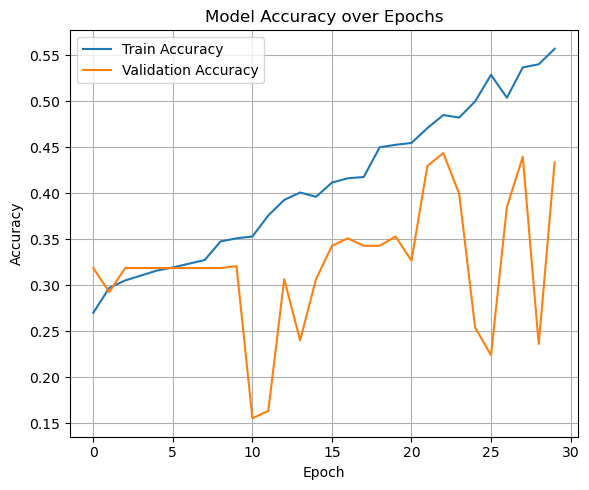

In [21]:
#Plot

plt.figure(figsize=(6, 5))
plt.plot(history_full.history['accuracy'], label='Train Accuracy')
plt.plot(history_full.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Clear Session

K.clear_session()
gc.collect()

0

In [23]:
# Add EarlyStopping to Multi-Class 

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Define the Model
model_multiclass_full2 = Sequential()
model_multiclass_full2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model_multiclass_full2.add(BatchNormalization())
model_multiclass_full2.add(MaxPooling2D((2, 2)))

model_multiclass_full2.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass_full2.add(BatchNormalization())
model_multiclass_full2.add(MaxPooling2D((2, 2)))

model_multiclass_full2.add(Conv2D(128, (3, 3), activation='relu'))
model_multiclass_full2.add(BatchNormalization())
model_multiclass_full2.add(MaxPooling2D((2, 2)))

model_multiclass_full2.add(GlobalAveragePooling2D())
model_multiclass_full2.add(Dense(128, activation='relu'))
model_multiclass_full2.add(Dropout(0.4))
model_multiclass_full2.add(Dense(len(species_keys), activation='softmax'))

# Compile the Model
model_multiclass_full2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history_full = model_multiclass_full2.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass_full2.evaluate(X_test, y_test)
print(f"\n Full dataset test accuracy: {acc:.4f}")

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.1997 - loss: 2.5512 - val_accuracy: 0.1331 - val_loss: 2.4048
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3000 - loss: 2.2451 - val_accuracy: 0.1331 - val_loss: 2.3450
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3401 - loss: 2.1612 - val_accuracy: 0.1331 - val_loss: 2.3759
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3031 - loss: 2.1656 - val_accuracy: 0.0948 - val_loss: 2.4362
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3000 - loss: 2.1798 - val_accuracy: 0.0988 - val_loss: 2.5922
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3623 - loss: 2.0944 - val_accuracy: 0.1028 - val_loss: 2.8979
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3393 - loss: 2.0636 - val_accuracy: 0.0988 - val_loss: 3.3272
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms

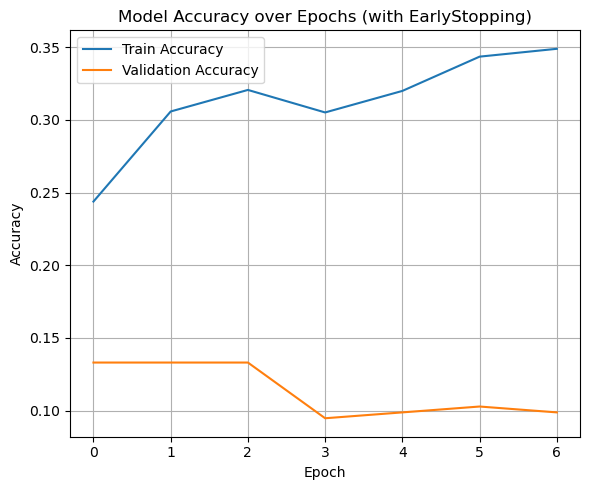

In [24]:
#Plot

plt.figure(figsize=(6, 5))
plt.plot(history_full.history['accuracy'], label='Train Accuracy')
plt.plot(history_full.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (with EarlyStopping)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Multi-Class with I Different Parameters (as per feedback)

model_multiclass1 = Sequential()
model_multiclass1.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 517, 1)))
model_multiclass1.add(BatchNormalization())
model_multiclass1.add(LeakyReLU())
model_multiclass1.add(MaxPooling2D((2, 2)))

model_multiclass1.add(Conv2D(64, (3, 3), padding='same'))
model_multiclass1.add(BatchNormalization())
model_multiclass1.add(LeakyReLU())
model_multiclass1.add(MaxPooling2D((2, 2)))
model_multiclass1.add(Dropout(0.3))

model_multiclass1.add(Conv2D(128, (3, 3), padding='same'))
model_multiclass1.add(BatchNormalization())
model_multiclass1.add(LeakyReLU())
model_multiclass1.add(MaxPooling2D((2, 2)))
model_multiclass1.add(Dropout(0.4))

model_multiclass1.add(GlobalAveragePooling2D())
model_multiclass1.add(Dense(256, activation='relu'))
model_multiclass1.add(Dropout(0.4))
model_multiclass1.add(Dense(len(species_keys), activation='softmax'))

model_multiclass1.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_multiclass1 = model_multiclass1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass1.evaluate(X_test, y_test)
print(f"\nFull dataset test accuracy: {acc:.4f}")

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 820ms/step - accuracy: 0.1636 - loss: 2.6353 - val_accuracy: 0.1512 - val_loss: 2.4460
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 759ms/step - accuracy: 0.2668 - loss: 2.2470 - val_accuracy: 0.3206 - val_loss: 2.3781
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 665ms/step - accuracy: 0.2863 - loss: 2.2516 - val_accuracy: 0.3185 - val_loss: 2.3067
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 662ms/step - accuracy: 0.3103 - loss: 2.2185 - val_accuracy: 0.3185 - val_loss: 2.2461
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 650ms/step - accuracy: 0.3100 - loss: 2.2080 - val_accuracy: 0.3185 - val_loss: 2.2189
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 648ms/step - accuracy: 0.3244 - loss: 2.1477 - val_accuracy: 0.3185 - val_loss: 2.2031
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1763s 19s/step - accuracy: 0.3067 - loss: 2.1872 - val_accuracy: 0.3185 - val_loss: 2.1753
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2957s 32s/step - accuracy: 0.3051 - loss: 2.1945 - val_accu

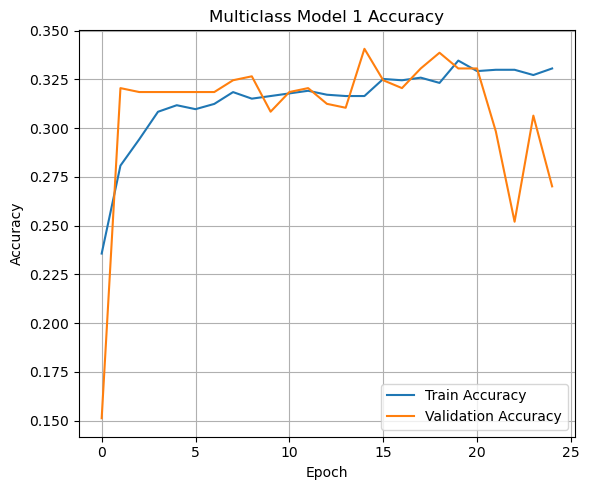

In [26]:
# Plot

plt.figure(figsize=(6, 5))
plt.plot(history_multiclass1.history['accuracy'], label='Train Accuracy')
plt.plot(history_multiclass1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multiclass Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Multi-Class with II Different Parameters (as per feedback)

model_multiclass2 = Sequential()
model_multiclass2.add(Conv2D(16, (5, 5), activation='relu', input_shape=(128, 517, 1)))
model_multiclass2.add(BatchNormalization())
model_multiclass2.add(AveragePooling2D((2, 2)))

model_multiclass2.add(Conv2D(32, (3, 3), activation='relu'))
model_multiclass2.add(BatchNormalization())
model_multiclass2.add(AveragePooling2D((2, 2)))
model_multiclass2.add(Dropout(0.25))

model_multiclass2.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass2.add(BatchNormalization())
model_multiclass2.add(AveragePooling2D((2, 2)))

model_multiclass2.add(GlobalAveragePooling2D())
model_multiclass2.add(Dense(64, activation='relu'))
model_multiclass2.add(Dropout(0.4))
model_multiclass2.add(Dense(len(species_keys), activation='softmax'))

model_multiclass2.compile(
    optimizer=RMSprop(learning_rate=1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_multiclass2 = model_multiclass2.fit(
    X_train, y_train,
    epochs=25,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass2.evaluate(X_test, y_test)
print(f"\nFull dataset test accuracy: {acc:.4f}")

Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.0711 - loss: 2.5588 - val_accuracy: 0.0706 - val_loss: 2.5106
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.1907 - loss: 2.3675 - val_accuracy: 0.1149 - val_loss: 2.4494
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.2590 - loss: 2.3217 - val_accuracy: 0.1573 - val_loss: 2.3783
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.2685 - loss: 2.3001 - val_accuracy: 0.2984 - val_loss: 2.3148
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.2887 - loss: 2.2773 - val_accuracy: 0.3145 - val_loss: 2.2780
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.2892 - loss: 2.2721 - val_accuracy: 0.3145 - val_loss: 2.2512
Epoch 7/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.2947 - loss: 2.2597 - val_accuracy: 0.3125 - val_loss: 2.2408
Epoch 8/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.2939 - loss: 2.2223 - val_accu

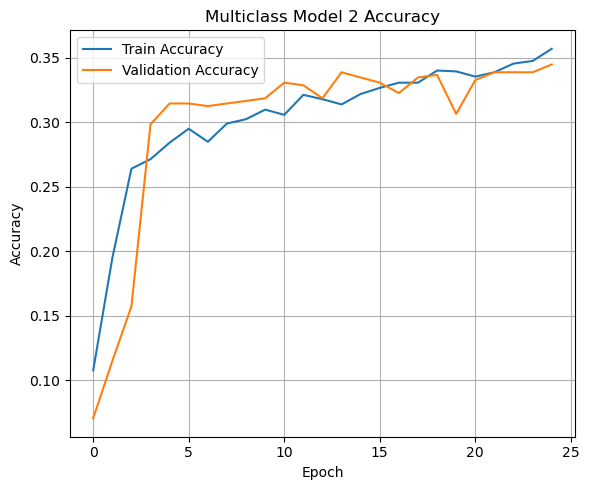

In [28]:
#PLot

plt.figure(figsize=(6, 5))
plt.plot(history_multiclass2.history['accuracy'], label='Train Accuracy')
plt.plot(history_multiclass2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multiclass Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


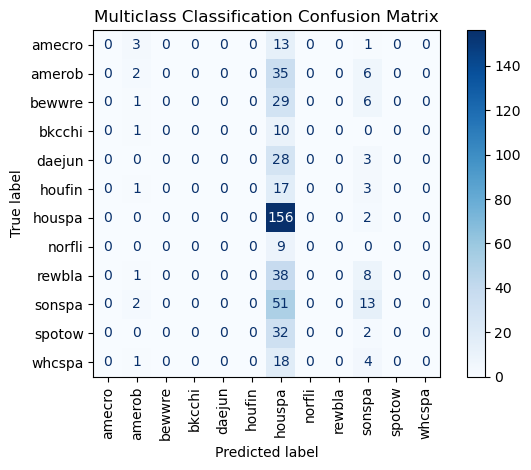

In [29]:
# Predict class probabilities
y_pred_probs = model_multiclass2.predict(X_test)

# Convert to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# PLot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Multiclass Classification Confusion Matrix")
plt.tight_layout()
plt.show()

### External Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
test1.mp3: Predicted species: ['House Sparrow', 'Dark-eyed Junco']
Multiple species likely present.


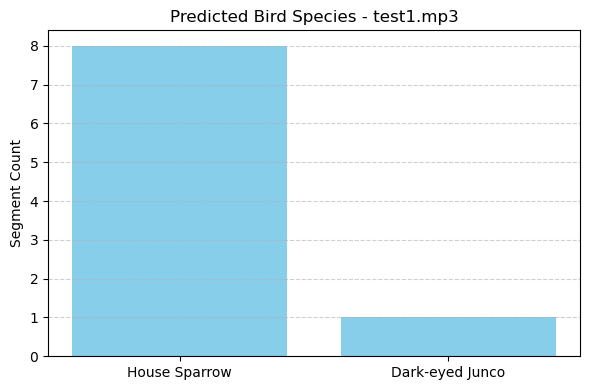

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
test2.mp3: Predicted species: ['House Sparrow']
Single species likely present.


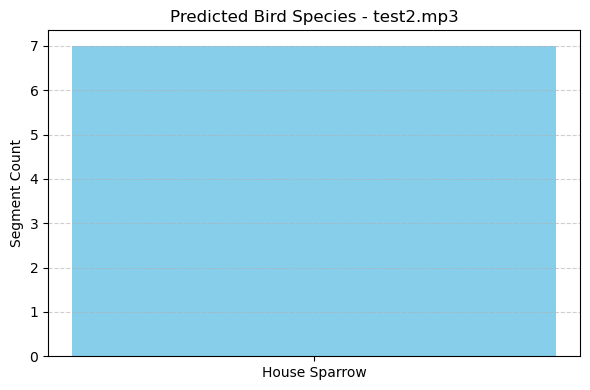

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
test3.mp3: Predicted species: ['House Sparrow', 'Dark-eyed Junco']
Multiple species likely present.


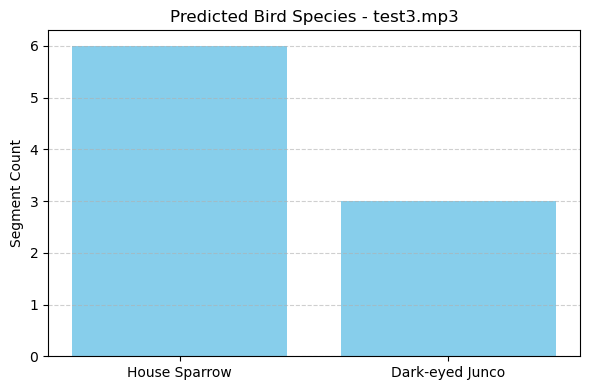

In [31]:
# Test MP3 File Paths
test_files = [
    "/Users/rich/Downloads/test1.mp3",
    "/Users/rich/Downloads/test2.mp3",
    "/Users/rich/Downloads/test3.mp3"]

# Mapping Labels 
species_fullnames = {
    'amecro': 'American Crow',
    'amerob': 'American Robin',
    'bewwre': "Bewick’s Wren",
    'bkcchi': 'Black-capped Chickadee',
    'daejun': 'Dark-eyed Junco',
    'houfin': 'House Finch',
    'houspa': 'House Sparrow',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'sonspa': 'Song Sparrow',
    'spotow': 'Spotted Towhee',
    'whcspa': 'White-crowned Sparrow'
}

# Spectrogram Extraction Function
def extract_spectrogram(filepath, start_sec=0, total_sec=6.0, stride=0.5, sr=22050):
    y, _ = librosa.load(filepath, sr=sr, offset=start_sec, duration=total_sec)
    window_size = int(2 * sr)
    step_size = int(stride * sr)
    spectrograms = []

    for start in range(0, len(y) - window_size + 1, step_size):
        y_seg = y[start:start + window_size]
        S = librosa.feature.melspectrogram(y=y_seg, sr=sr, n_mels=128, hop_length=128, win_length=512)
        S_db = librosa.power_to_db(S, ref=np.max)
        S_db = librosa.util.fix_length(S_db, size=517, axis=1)
        max_val = np.max(S_db)
        S_db = S_db / max_val if max_val > 0 else np.zeros_like(S_db)
        S_db = S_db[..., np.newaxis]  

        
        spectrograms.append(S_db)

    return np.array(spectrograms)

# Prediction and Plotting
def predict_and_plot(filepath, model, label_encoder, start_sec=0, total_sec=6.0):
    specs = extract_spectrogram(filepath, start_sec, total_sec)
    if specs.shape[0] == 0:
        print(f"{os.path.basename(filepath)}: no valid segments found.")
        return

    preds = model.predict(specs)
    pred_classes = np.argmax(preds, axis=1)
    pred_labels = label_encoder.inverse_transform(pred_classes)
    summary = Counter(pred_labels)

    # Map to full species names
    full_summary = {species_fullnames.get(k, k): v for k, v in summary.items()}

    # Print Prediction
    print(f"{os.path.basename(filepath)}: Predicted species: {list(full_summary.keys())}")
    if len(full_summary) > 1:
        print("Multiple species likely present.")
    else:
        print("Single species likely present.")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(full_summary.keys(), full_summary.values(), color='skyblue')
    plt.title(f"Predicted Bird Species - {os.path.basename(filepath)}")
    plt.ylabel("Segment Count")
    plt.xticks(rotation=0, ha='center') 
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Predict and Plot
for file in test_files:
    predict_and_plot(file, model_multiclass_full1, label_encoder)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step


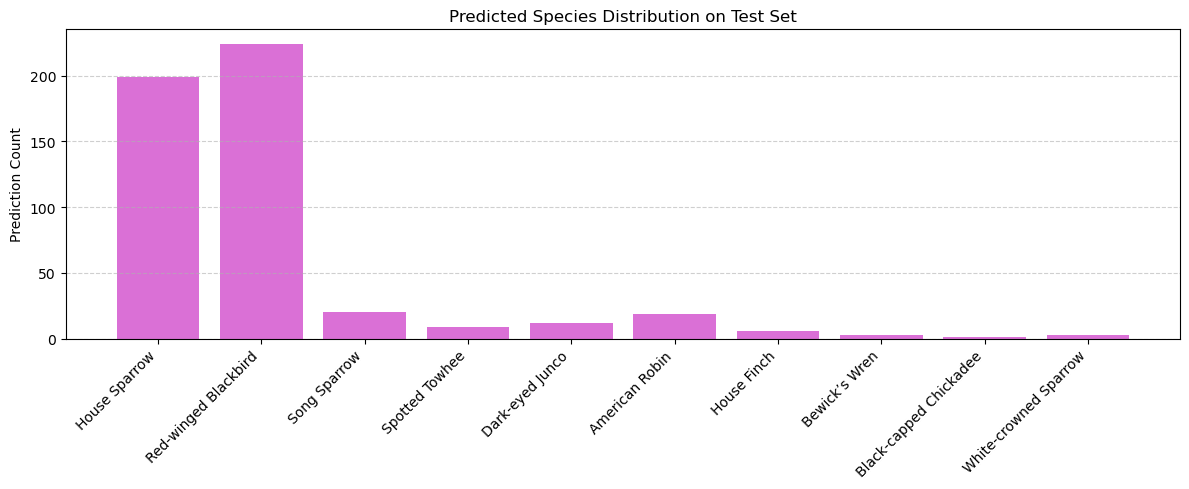

In [32]:
# Run model on all test spectrograms
y_pred_probs = model_multiclass_full1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Count predicted class frequency
pred_counts = Counter(label_encoder.inverse_transform(y_pred))
true_counts = Counter(label_encoder.inverse_transform(y_true))

# Plot
labels = [species_fullnames[k] for k in pred_counts.keys()]
pred_vals = list(pred_counts.values())

plt.figure(figsize=(12, 5))
plt.bar(labels, pred_vals, color='orchid')
plt.title("Predicted Species Distribution on Test Set")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Prediction Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()